In [1]:
import numpy as np

# Here is what `poliastro` does at the moment ...

It heavily relies on `numpy` functions and tosses `ndarray` objects around. The notations is easy an readable.

In [2]:
from numba import njit, vectorize

@njit
def norm(arr):
    return np.sqrt(arr @ arr)

@njit
def eccentricity_vector(k, r, v):
    return ((v @ v - k / norm(r)) * r - (r @ v) * v) / k

@vectorize('f8(f8)', target = 'cpu', nopython = True)
def test_arraystyle(d):
    return np.sum(eccentricity_vector(d, np.array([d + 1, d + 2, + 3]), np.array([d + 4, d + 5, d + 6])))

# Here is what `poliastro` could be doing ...

A number of `numpy` functions have to go. Most can be substituted rather easily. Besides, and that is a little more work, the core data structures for vectors (and matrices) have to shift to "good old" tuples. Yes, immutable tuples, you have read correctly. The first added benefit: The code generically compiles for `cpu`, `parallel` and `cuda` targets. The surprising second added benefit: Even on the `cpu` target, this makes the code actually faster (contrary to all intuition).

Notice that there are two new `jit` decorators, located in `poliastro.core.jit`. They handle target switching, inlining and expansion of otherwise annoying signatures (`V` for instance expands to `["Tuple([f4,f4,f4])", "Tuple([f8,f8,f8])"]`).

In [3]:
from math import sqrt  # almost all basic math has to be shifted to `math`
import os

os.environ['POLIASTRO_TARGET'] = 'cpu'  # can be set to `cpu`, `parallel` or `cuda`
from poliastro.core.jit import vjit, hjit, TARGET

print(TARGET)  # verfication

cpu


Just for clarification: `cpu` does not just mean CPU. In means *one single thread*.

In [4]:
@hjit('f(V,V)')
def matmul_(a, b):
    return a[0] * b[0] + a[1] * b[1] + a[2] * b[2]

@hjit('f(V)')
def norm_(a):
    return sqrt(matmul_(a, a))

@hjit('V(f,V,V)')
def eccentricity_vector_(k, r, v):
    a = matmul_(v, v) - k / norm_(r)
    b = matmul_(r, v)
    # no sane way of turning this into a for-loop -> numba bugs, need to investigate this further
    # alternative: going all-in on Haskel-style
    return (
        (a * r[0] - b * v[0]) / k,
        (a * r[1] - b * v[1]) / k,
        (a * r[2] - b * v[2]) / k,
    )

@vjit('f(f)')
def test_tuplestyle(d):
    return sum(eccentricity_vector_(d, (d + 1, d + 2, + 3), (d + 4, d + 5, d + 6)))

# Verification of results

In [5]:
funcs = [
    test_arraystyle,
    test_tuplestyle,
]

In [6]:
def test_all(size = 100):
    
    data = np.random.random(size) * 128 + 1
    res_base = funcs[0](data)
    
    for func in funcs[1:]:
        res = func(data)
        assert np.allclose(res_base, res)
        
test_all()

# Benchmark

In [7]:
import gc
from time import time_ns
from tqdm import tqdm

In [8]:
def _name(func):
    try:
        return func.__name__
    except AttributeError:  # numba#8272
        return list(func.functions.values())[0][1].py_func.__name__[13:]

def benchmark(start = 4, stop = 25, reps = 2):
    sizes = (2 ** np.arange(start, stop + 0.5, 0.5)).astype('i8')
    results = {_name(func): [] for func in funcs}
    gc.disable()
    for size in tqdm(sizes):
        data = np.arange(1, size + 1, 1, dtype = 'f8')
        for func in funcs:
            runtimes = []
            for rep in range(reps):
                assert data.dtype == np.float64
                gc.collect()
                start = time_ns()
                result = func(data)
                runtime = time_ns() - start
                runtimes.append(runtime)
                assert result.dtype == np.float64
            results[_name(func)].append(min(runtimes) * 1e-9)
    gc.enable()
    return sizes, results

s, r = benchmark()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:41<00:00,  1.03it/s]


# Analysis / plots

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

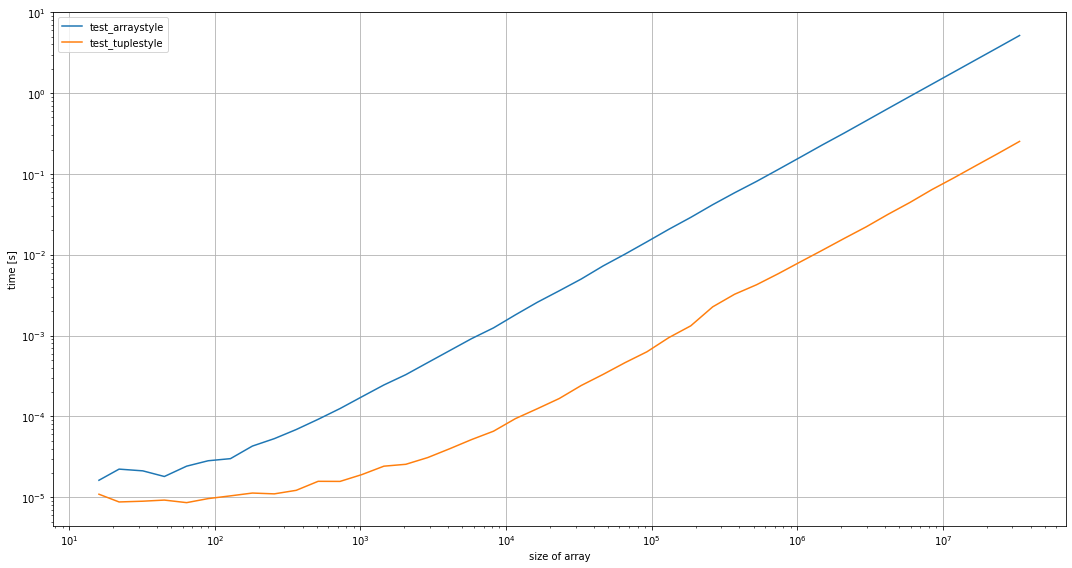

In [10]:
def plot_all(sizes, results):
    fig, ax = plt.subplots(figsize = (15, 8))
    for name, values in results.items():
        ax.loglog(sizes, values, label = name)
    ax.legend()
    ax.set_xlabel('size of array')
    ax.set_ylabel('time [s]')
    ax.grid()
    fig.tight_layout()
    fig.savefig('plot_all.jpg')

plot_all(s, r)

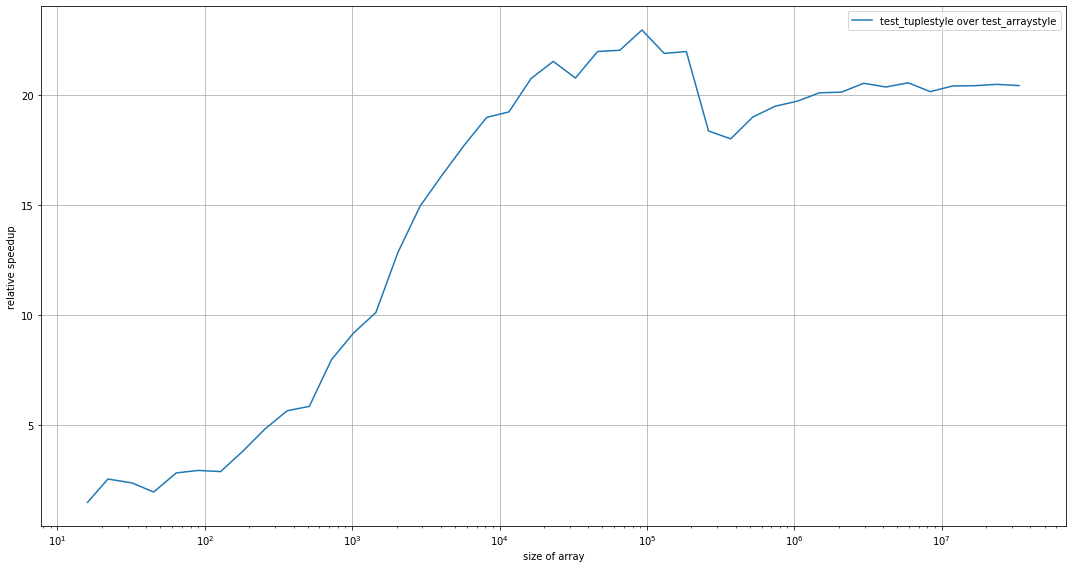

In [11]:
def plot_relative_speedup(sizes, results, pairs):
    fig, ax = plt.subplots(figsize = (15, 8))
    for base, faster in pairs:
        ax.semilogx(
            sizes,
            np.array(r[base]) / np.array(r[faster]),
            label = f'{faster:s} over {base:}',
        )
    ax.legend()
    ax.set_xlabel('size of array')
    ax.set_ylabel('relative speedup')
    ax.grid()
    fig.tight_layout()
    fig.savefig('plot_relative_speedup.jpg')

plot_relative_speedup(s, r, pairs = [
    ('test_arraystyle', 'test_tuplestyle'),
])